In [1]:
#!pip install keras_tuner
# Grundlæggende pakker
import numpy as np
import pandas as pd

from statsmodels.tsa.ar_model import AutoReg
from sklearn.preprocessing import MinMaxScaler

import os
import sys
import csv
import logging
import importlib

ROOT_PATH = '/Users/rasmusklitteandersen/Library/CloudStorage/GoogleDrive-rasmusklitteandersen@gmail.com/Mit drev/speciale/'

# Naive model

In [ ]:
# Set up paths and configurations
#ROOT_PATH = '/content/drive/MyDrive/speciale/'
sys.path.append(ROOT_PATH)
os.chdir(ROOT_PATH)

# Import custom utilities and modules
from utils.misc import LoadData, EvaluationMetric, Plotting
from utils import metrics 


# ===== CONFIGURATION SECTION =====
# Paths
DATA_PATH = f'{ROOT_PATH}data/final_dataset_test.csv'
MODEL_PATH = f'{ROOT_PATH}models/'
IMAGE_PATH = f'{ROOT_PATH}/images/'
LOG_DIR = f'{MODEL_PATH}/logs/'
TUNING_DIR = f'{MODEL_PATH}/tuning/'
RESULTS_DIR = f'{ROOT_PATH}results/'
TABLES_DIR = f'{ROOT_PATH}tables/'

# Flags and Options
INCLUDE_LAGS = True
INCLUDE_SEASON_VARS = True
INCLUDE_WEATHER = True
TEST = False
TIME_START = '2019-10-31'
TIME_END = '2021-09-30'
TIME_END_PERIODS = ['2021-09-30', '2023-01-01', '2024-07-01']
MODELS = ['LSTM', 'TCN', 'Hybrid', 'Transformer']
TUNER = ''

# Generate dynamic strings based on flags
def get_extra_info():
    extra_info = ''
    if not INCLUDE_WEATHER:
        extra_info += '_no_weather'
    if not INCLUDE_LAGS:
        extra_info += '_no_lags'
    if not INCLUDE_SEASON_VARS:
        extra_info += '_no_season_vars'
    return extra_info

# ===== LOGGING SETUP =====
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()

# ===== FUNCTIONS =====
def reload_utils_misc():
    """Function to reload utils.misc module if changes are made."""
    import utils.misc
    importlib.reload(utils.misc)

def setup_directories(test_mode):
    """Set up directories based on whether TEST mode is enabled."""
    test_suffix = 'test/' if test_mode else ''
    return {
        'image_path': f"{IMAGE_PATH}{test_suffix}",
        'log_dir': f"{LOG_DIR}{test_suffix}",
        'tuning_dir': f"{TUNING_DIR}{test_suffix}",
        'results_dir': f"{RESULTS_DIR}{test_suffix}",
        'tables_dir': f"{TABLES_DIR}{test_suffix}"
    }

def initialize_data_loader():
    """Initialize the data loading utility with required flags."""
    return LoadData(INCLUDE_LAGS, INCLUDE_SEASON_VARS, INCLUDE_WEATHER, TUNER)

def initialize_evaluation_metric():
    """Initialize the evaluation metric utility with required flags."""
    return EvaluationMetric(INCLUDE_LAGS, INCLUDE_SEASON_VARS, INCLUDE_WEATHER, TUNER)

# ===== MAIN SCRIPT =====
if __name__ == "__main__":
    # Setup directories based on TEST mode
    dirs = setup_directories(TEST)
    extra_info = get_extra_info()
    
    # Reload utils if changes were made
    reload_utils_misc()

    # Initialize components
    load_data = initialize_data_loader()
    evaluation_metric = initialize_evaluation_metric()

    # Set random seeds for reproducibility
    #tf.random.set_seed(14)
    np.random.seed(14)

    # Log basic configuration
    logger.info(f"Starting training with configuration:")
    logger.info(f"Data path: {DATA_PATH}")
    logger.info(f"Model path: {MODEL_PATH}")
    logger.info(f"Include Lags: {INCLUDE_LAGS}, Include Season Vars: {INCLUDE_SEASON_VARS}, Include Weather: {INCLUDE_WEATHER}")

In [4]:
MODEL = 'Naive'
load_data = LoadData(INCLUDE_LAGS, INCLUDE_SEASON_VARS, INCLUDE_WEATHER)
df, TIME_PERIOD = load_data.load_and_preprocess_data(DATA_PATH, TIME_START, TIME_END)
log_dir, tuning_dir = load_data.setup_directories(LOG_DIR, TUNING_DIR, TIME_PERIOD, MODEL)
datasets, y, X_train, X_test, scaler_y, y_test = load_data.split_and_scale_data(df)

prices = df.iloc[len(df) - len(datasets['y_test']):, [df.columns.get_loc('Day Ahead Spot Price')]]
prices  = pd.DataFrame(prices)

# Opret en ny kolonne til prediction
prices['forecast'] = None

# Beregn forecast for hver time ved at tage gennemsnittet af den foregående uges tilsvarende tidspunkter
def rolling_forecast(df, window_size=24*7):  # window_size for en hel uge
    for current_time in df.index[window_size:]:  # Start fra den første komplette uge fremad
        # Slut her er aktuelt tidspunkt minus en uge
        window_start = current_time - pd.Timedelta(days=7)
        
        # Slice med de seneste syv dage frem til current_time (ikke inklusive)
        relevant_data = df.loc[window_start:current_time, 'Day Ahead Spot Price']
        
        # Beregn gennemsnit for disse data
        df.at[current_time, 'forecast'] = relevant_data.mean()

# Anvend funktionen til at beregne forecast
rolling_forecast(prices)

In [ ]:
test_metrics = metrics.evaluate_all(np.array(datasets['y_test']), prices['forecast'])
logger.info('Test scores:')
logger.info(test_metrics)

with open(f'{RESULTS_DIR}/metrics/{MODEL}/{MODEL}_test_metrics_{TIME_PERIOD}.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Metric', 'Value'])
    for key, value in test_metrics.items():
        writer.writerow([key, value])

In [ ]:
plotting = Plotting(MODEL, TIME_PERIOD, IMAGE_PATH, INCLUDE_LAGS, INCLUDE_SEASON_VARS, INCLUDE_WEATHER)
plotting.plot_predictions(df, y, X_train, X_test, prices['forecast'])

# AR-X

In [ ]:
import statsmodels.api as sm

INCLUDE_LAGS = True
INCLUDE_SEASON_VARS = True
INCLUDE_WEATHER = True
MODEL = 'AR-X'
TIME_END = '2024-07-01'
#TIME_END_PERIODS = ['2021-09-30', '2023-01-01', '2024-07-01']
load_data = LoadData(INCLUDE_LAGS, INCLUDE_SEASON_VARS, INCLUDE_WEATHER)
df, TIME_PERIOD = load_data.load_and_preprocess_data(DATA_PATH, TIME_START, TIME_END)
log_dir, tuning_dir = load_data.setup_directories(LOG_DIR, TUNING_DIR, TIME_PERIOD, MODEL)
datasets, y, X_train, X_test, scaler_y, y_test = load_data.split_and_scale_data(df)
plotting = Plotting(MODEL, TIME_PERIOD, IMAGE_PATH, INCLUDE_LAGS, INCLUDE_SEASON_VARS, INCLUDE_WEATHER)
print(df.head())


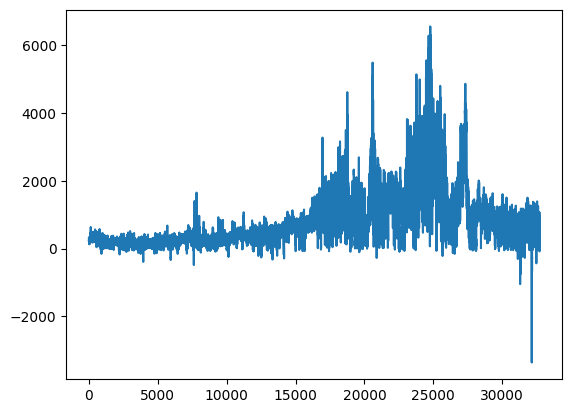

In [25]:

# Load data and separate 'Day Ahead Spot Price' as the endogenous variable
data = df['Day Ahead Spot Price'].values.reshape(-1, 1)  # Endogenous variable
exog = df.drop(columns=['Day Ahead Spot Price']).values  # All other variables as exogenous

# Handle any NaN values
data = np.nan_to_num(data)
exog = np.nan_to_num(exog)

# Split data into training and test sets
train_size = int(len(data) * 0.8)
train_data, test_data = data[:train_size].flatten(), data[train_size:].flatten()
train_exog, test_exog = exog[:train_size], exog[train_size:]

# Define parameters
sequence_length = 24 * 2   # Use the last 7 days (168 hours) to predict the next 24 hours
prediction_length = 24     # Forecast the next 24 hours

# Iterative forecasting for the entire test set using AR-X
predictions = []
history_data = list(train_data)  # History for endogenous data
history_exog = list(train_exog)  # History for exogenous variables

# Convert history_exog to numpy array and select the last `sequence_length` rows
history_exog_array = np.array(history_exog)

mod = AutoReg(endog=history_data, lags=2, exog=history_exog)
res = mod.fit()
pred = res.predict(exog_oos=test_exog)


plt.plot(pred)

In [ ]:

# Load data and separate 'Day Ahead Spot Price' as the endogenous variable
data = df['Day Ahead Spot Price'].values.reshape(-1, 1)  # Endogenous variable
exog = df.drop(columns=['Day Ahead Spot Price']).values  # All other variables as exogenous

# Handle any NaN values
data = np.nan_to_num(data)
exog = np.nan_to_num(exog)

mod = AutoReg(endog=history_data, lags=2, exog=history_exog)
res = mod.fit()
pred = res.predict(start=length_train+1, end=length_train+1, exog_oos=X[10][length_train-1+i].reshape(-1,22))
pred_ARX[i,hour] = pred.values

# Split data into training and test sets
train_size = int(len(data) * 0.8)
train_data, test_data = data[:train_size].flatten(), data[train_size:].flatten()
train_exog, test_exog = exog[:train_size], exog[train_size:]

# Define parameters
sequence_length = 24 * 2   # Use the last 7 days (168 hours) to predict the next 24 hours
prediction_length = 24     # Forecast the next 24 hours

# Iterative forecasting for the entire test set using AR-X
predictions = []
history_data = list(train_data)  # History for endogenous data
history_exog = list(train_exog)  # History for exogenous variables

# Convert history_exog to numpy array and select the last `sequence_length` rows
history_exog_array = np.array(history_exog)

mod = AutoReg(endog=history_data, lags=2, exog=history_exog)
res = mod.fit()
pred = res.predict(exog_oos=test_exog)
#pred_ARX[i,hour] = pred.values


# Train AR-X model on the most recent sequence_length data points
model = AutoReg(endog=history_data, lags=2, exog=history_exog_array)
model_fit = model.fit()
# Get all model parameters
print(model_fit.summary())

for i in range(0, len(test_data) - sequence_length, prediction_length):
   
    # Forecast the next 24 hours using the corresponding exogenous variables
    # Setting start=0 and end=prediction_length-1 to only forecast 24 steps
    forecast = model_fit.predict(
        start=0,
        end=prediction_length - 1,
        exog_oos=test_exog[i:i + prediction_length]
    )
    predictions.extend(forecast)

    # Update the history with the latest actual values and exogenous variables
    history_data.extend(test_data[i:i + prediction_length])
    history_exog.extend(test_exog[i:i + prediction_length])

# Inverse transform the predictions and actual values to original scale
predictions = np.array(predictions).reshape(-1, 1).flatten()
actual_values = test_data[:len(predictions)].reshape(-1, 1).flatten()


plotting = Plotting(MODEL, TIME_PERIOD, IMAGE_PATH, INCLUDE_LAGS, INCLUDE_SEASON_VARS, INCLUDE_WEATHER, TUNER)
plotting.plot_predictions(df, y, X_train, X_test, predictions)

test_metrics = metrics.evaluate_all(actual_values, np.nan_to_num(predictions))
logger.info('Test scores:')
logger.info(test_metrics)

with open(f'{RESULTS_DIR}/metrics/{MODEL}/{MODEL}_test_metrics_{TIME_PERIOD}{extra_info}.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Metric', 'Value'])
    for key, value in test_metrics.items():
        writer.writerow([key, value])



# AR

In [ ]:
# Importér nødvendige biblioteker
from statsmodels.tsa.arima.model import ARIMA

MODEL = 'AR'
df, TIME_PERIOD = load_data.load_and_preprocess_data(DATA_PATH, TIME_START, TIME_END)
data = df['Day Ahead Spot Price'].values.reshape(-1, 1)

# Tjek og håndter eventuelle NaN-værdier
data = np.nan_to_num(data)

# Split data i trænings- og testdata
train_size = int(len(data) * 0.8)
train_data, test_data = data[:train_size].flatten(), data[train_size:].flatten()

# Definér parametre
sequence_length = 24 * 7   # Brug de seneste 7 dage (168 timer) til at forudsige de næste 24 timer
prediction_length = 24     # Forudsige de næste 24 timer

# Iterativ forudsigelse for hele test-sættet med ARIMA
predictions = []
history = list(train_data)  # Brug træningsdata som historik til ARIMA-modellen

# Træn ARIMA-modellen på den aktuelle historik
model = ARIMA(history, order=(2,0,0))  
model_fit = model.fit()

for i in range(0, len(test_data) - sequence_length, prediction_length):
    
    # Forudsig de næste 24 timer
    forecast = model_fit.forecast(steps=prediction_length)
    predictions.extend(forecast)

    # Opdater historikken med de nyeste forudsigelser
    history.extend(test_data[i:i + prediction_length])

# Inverse transform the predictions and actual values to original scale
predictions = np.array(predictions).reshape(-1, 1).flatten()
actual_values = test_data[:len(predictions)].reshape(-1, 1).flatten()

test_metrics = metrics.evaluate_all(actual_values, np.nan_to_num(predictions))
logger.info('Test scores:')
logger.info(test_metrics)

with open(f'{RESULTS_DIR}/metrics/{MODEL}/{MODEL}_test_metrics_{TIME_PERIOD}.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Metric', 'Value'])
    for key, value in test_metrics.items():
        writer.writerow([key, value])

log_dir, tuning_dir = load_data.setup_directories(LOG_DIR, TUNING_DIR, TIME_PERIOD, MODEL)
datasets, y, X_train, X_test, scaler_y, y_test = load_data.split_and_scale_data(df)
plotting = Plotting(MODEL, TIME_PERIOD, IMAGE_PATH, INCLUDE_LAGS, INCLUDE_SEASON_VARS, INCLUDE_WEATHER, TUNER)
plotting.plot_predictions(df, y, X_train, X_test, predictions)

# ARMA

In [ ]:


# Vælg en AR-orden, f.eks. p = 3 (justér efter behov)
MODEL = 'ARMA'
df, TIME_PERIOD = load_data.load_and_preprocess_data(DATA_PATH, TIME_START, TIME_END)
data = df['Day Ahead Spot Price'].values.reshape(-1, 1)

# Tjek og håndter eventuelle NaN-værdier
data = np.nan_to_num(data)

# Split data i trænings- og testdata
train_size = int(len(data) * 0.8)
train_data, test_data = data[:train_size].flatten(), data[train_size:].flatten()

# Definér parametre
sequence_length = 24 * 7   # Brug de seneste 7 dage (168 timer) til at forudsige de næste 24 timer
prediction_length = 24     # Forudsige de næste 24 timer

# Iterativ forudsigelse for hele test-sættet med ARIMA
predictions = []
history = list(train_data)  # Brug træningsdata som historik til ARIMA-modellen

# Træn ARIMA-modellen på den aktuelle historik
model = ARIMA(history, order=(2,0,2))  
model_fit = model.fit()

for i in range(0, len(test_data) - sequence_length, prediction_length):
    
    # Forudsig de næste 24 timer
    forecast = model_fit.forecast(steps=prediction_length)
    predictions.extend(forecast)

    # Opdater historikken med de nyeste forudsigelser
    history.extend(test_data[i:i + prediction_length])

# Invers transformer forudsigelserne og faktiske værdier til oprindelig skala
# Inverse transform the predictions and actual values to original scale
predictions = np.array(predictions).reshape(-1, 1).flatten()
actual_values = test_data[:len(predictions)].reshape(-1, 1).flatten()

test_metrics = metrics.evaluate_all(actual_values, predictions)
logger.info('Test scores:')
logger.info(test_metrics)

with open(f'{RESULTS_DIR}/metrics/{MODEL}/{MODEL}_test_metrics_{TIME_PERIOD}.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Metric', 'Value'])
    for key, value in test_metrics.items():
        writer.writerow([key, value])

log_dir, tuning_dir = load_data.setup_directories(LOG_DIR, TUNING_DIR, TIME_PERIOD, MODEL)
datasets, y, X_train, X_test, scaler_y, y_test = load_data.split_and_scale_data(df)
plotting = Plotting(MODEL, TIME_PERIOD, IMAGE_PATH, INCLUDE_LAGS, INCLUDE_SEASON_VARS, INCLUDE_WEATHER, TUNER)
plotting.plot_predictions(df, y, X_train, X_test, predictions)

In [ ]:
# Fit AR-X modellen
model = sm.OLS(history_data, history_exog).fit()

# Print resultaterne
print(model.summary())

# Forudsigelser på testdata
y_pred = model.predict(X_test)

# Evaluering af modellen
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")

# Plot resultaterne
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test.index, history_data, label="Actual")
plt.plot(y_test.index, y_pred, label="Predicted", linestyle="--")
plt.legend()
plt.title("AR-X Model Predictions")
plt.xlabel("Date")
plt.ylabel("y")
plt.show()